# Team 6 CT Classification

## Climate Change Sentiment analysis - 2020

### Project Description


>Many companies are built around lessening one‚Äôs environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.
>
>With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.
>
>Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

https://www.kaggle.com/c/climate-change-belief-analysis/overview

### Project Description

>Build a sentiment analysis model to predict whether a person is for, against, or neutral towards climate change based off of a tweet

![alt text](https://images.unsplash.com/photo-1578825141469-690ba22eede0?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1051&q=80)
<span>Photo by <a href="https://unsplash.com/@markusspiske?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Markus Spiske</a> on <a href="/s/photos/business-dead-planet?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

### Notebook Explanation

First, we tried 5 base models with no preprocessing of the text to get a benchmark score. We then extracted info from the tweets and added additional columns such as character and words count.

The next step was cleaning the tweets. For example, we removed the URLs, the <i>'RT'</i> retweet tags and the mentions. We applied both stemming and lemmatisation normalising methods to test which performs better. Following that, we vectorized the text using 3 methods: Count Vectoriser, TD-IDF and Word2Vec. We added additional columns for each of the combinations of methods and ran each combination through the base models again with cross validation and compared the performance. This was an iterative process until we got the best performing cleaning method.

After deciding on the best cleaning method, we did an Exploratory data analysis (EDA) on the tweets and retrieved data about mentions and hashtags. We also did EDA on the categorised tweets to extract insights from the different sentiment labels.

Next, we compared the base models with unprocessed and processed tweets. We selected the top 2 performing models and used GridSearchCV to find the best parameters to train these models with. We compared the F1 score and selected the best performing model.

Below is a model process flow diagram visualising the approach we took to solve this problem.

This notebook does not contain all the methods and options that can be seen in the flow diagram. It only contains some of the methods we tried in text cleaning, vectorising and basic models. We tried more complex models, but none of which gave us a better score as the simple models yet.


<img src="resources/Model Process Flow.png" />

<a id = "top"></a>

# Table of contents

1. [Importing packages](#packages) <br><br>

2. [Loading and viewing data](#data) <br><br>

3. [Data description](#description) <br><br>

4. [Sentiment description](#sentiment)<br><br>

5. [Data extraction](#extraction)<br><br>

6. [Text cleaning](#cleaning) <br><br>

7. [Exploratory data analysis](#eda)<br><br>

8. [Balancing dataset](#balance) <br><br>

9. [Base model](#base) <br><br>

10. [Model evaluation & optimisation](#evaluation) <br><br>

11. [Conclusion](#conclusion) <br><br>

# 1. Importing packages <a name="packages"></a>
[Return to top](#top) <br><br>

The following packages need to be installed on your local machine.

- matplotlib==3.2.2
- nltk==3.5
- numpy==1.18.5
- pandas==1.0.5
- scikit-learn==0.23.1
- seaborn==0.10.1
- spacy==2.2.4
- wordcloud==1.6.0

In [1]:
%%capture
!pip install ipython-autotime

%load_ext autotime

In [2]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

time: 1e+03 ¬µs


In [3]:
# Processing
import numpy as np
import pandas as pd
import re


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Spacy packages
import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS

# NLTK packages
import nltk
from nltk.tokenize import word_tokenize,TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt', quiet=True)

# Sklearn packages
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn_pandas import DataFrameMapper

# Utils
from collections import Counter
import itertools, string, operator, re, unicodedata, nltk
from wordcloud import WordCloud

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


time: 3.87 s


In [4]:
# These nltk packages need to be downloaded - uncomment to download

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')

Error in callback <function LineWatcher.stop at 0x000002ACA5436950> (for post_run_cell):


AssertionError: 

# 2. Loading  and viewing data <a name="data"></a>
[Return to top](#top) <br><br>


- Data loads from Github repository
- Training dataset has 15819 entries
- Testing dataset has 10546 entries
- Viewing the first 5 rows of datasets


In [5]:
# Import data
train_df = pd.read_csv('https://raw.githubusercontent.com/jonnybegreat/test-repo/master/twitter_train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/jonnybegreat/test-repo/master/twitter_test.csv')


time: 5.88 s


In [6]:
# Make copy of train_df assigning to variable df and view the first 5 rows
df = train_df.copy()
df.head()


sentiment                                            message  tweetid
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221
1          1  It's not like we lack evidence of anthropogeni...   126103
2          2  RT @RawStory: Researchers say we have three ye...   698562
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954

time: 13 ms


In [7]:
# View the first 5 rows of test dataset
test_df.head()


message  tweetid
0  Europe will now be looking to China to make su...   169760
1  Combine this with the polling of staffers re c...    35326
2  The scary, unimpeachable evidence that climate...   224985
3  @Karoli @morgfair @OsborneInk @dailykos \nPuti...   476263
4  RT @FakeWillMoore: 'Female orgasms cause globa...   872928

time: 5 ms


# 3. Data description <a name="description"></a>
[Return to top](#top) <br><br>

<b>Training data columns (15819 entries):</b>
- Sentiment - Labelled sentiment classification
- Message - Tweet to analysed
- Tweet ID - ID of unique tweet

<b>Test data columns (10546 entries):</b>
- Message - Tweet to be analysed
- Tweet ID - ID of unique tweet


<i>Training data info and data types:</i>

In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB
time: 6.99 ms


<i>Testing data info and data types:</i>

In [9]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10546 entries, 0 to 10545
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  10546 non-null  object
 1   tweetid  10546 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 164.9+ KB
time: 7 ms


# 4. Sentiment description <a name="sentiment"></a>
[Return to top](#top) <br><br>

The table displays the description of each sentiment category:

![alt text](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F2205222%2F8e4d65f2029797e0462b52022451829c%2Fdata.PNG?generation=1590752860255531&alt=media)

<i>How many tweets are there in each category?</i>

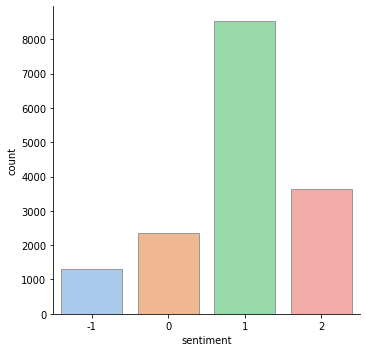

time: 201 ms


In [10]:
#Bar graph of sentiment count
sns.catplot(x = 'sentiment', kind = 'count', edgecolor = '.6',
            palette = 'pastel', data = df);


Majority of the tweets are positive(1) towards climate change. The least amount of tweets are negative (-1) towards climate change. This shows data is unbalanced and can affect our prediction results. Later in this notebook, we will explore resampling methods to balance the data.

# 5. Data extraction <a name="extraction"></a>
[Return to top](#top) <br><br>


Create new columns of the following features of the tweets:
- Tokenise tweet
- Categorise as retweet or not
- Hashtag extraction and count
- Mention extraction and count
- Word and character count
- Average word length
- Stop word count per

All of the above methods are applied to the test data as well.

In [11]:
# Create copies of train and test dataframes
df_with_metadata = df.copy()
test_df_with_metadata = test_df.copy()


time: 1.98 ms


In [12]:
def hashtag_column(x):
    '''
    This function extracts hashtags from tweets and
    adds them to a new hashtags column.
    '''
    hashtags = []
    new_tag_list = []
        
    #Find all the items that start with a '#'
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)         
    
    #Replace empty tag lists with NaN
    for tag in hashtags:
        if tag == []:
            tag = np.nan
        new_tag_list.append(tag)
        
    return new_tag_list


time: 1.01 ms


In [13]:
# Mentions function - NEEDS TO BE EDITED TO INCLUDE MULTIPLE MENTIONS
def mention_column(x):
    '''
    This function extracts mentions from tweets and
    add it to a new hashtags column.
    '''
    mentions = []
    new_mention_list = []

    #Find all the items that start with a '@'
    for i in x:
        ht = re.findall(r"@(\w+)", i)
        mentions.append(ht)         

    #Replace empty mention lists with NaN        
    for tag in mentions:
        if tag == []:
            tag = np.nan
        new_mention_list.append(tag)
        
    return new_mention_list


time: 1e+03 ¬µs


In [14]:
# Tokenized tweet - apply word_tokenize from NLTK
df_with_metadata['message_token'] = df_with_metadata['message'].apply(lambda x: word_tokenize(x))


time: 3.19 s


In [15]:
# Categorise as retweet or not

#New 'retweet' column to return yes if the first 2 characters is 'RT', else return no
df_with_metadata['retweet'] = ['yes' if df_with_metadata['message'][i][:2] == 'RT' 
                               else 'no' for i in range(len(df_with_metadata))]


time: 219 ms


In [16]:
# Create new column 'hashtags' and extract hashtags with hashtag_column function.
df_with_metadata['hashtags'] = hashtag_column(df_with_metadata['message'])

test_df_with_metadata['hashtags'] = hashtag_column(test_df_with_metadata['message'])

#Count how many times a word starts with #
df_with_metadata['hashtag_count'] = df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word.startswith('#')]))

test_df_with_metadata['hashtag_count'] = test_df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word.startswith('#')]))


time: 204 ms


In [17]:
# Create new column 'mentions' and extract mentions with mention_column function.
df_with_metadata['mentions'] = mention_column(df_with_metadata['message'])

test_df_with_metadata['mentions'] = mention_column(test_df_with_metadata['message'])

#Count how many times a word starts with @
df_with_metadata['mention_count'] = df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word.startswith('@')]))

test_df_with_metadata['mention_count'] = test_df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word.startswith('@')]))


time: 157 ms


In [18]:
# Character count
df_with_metadata['char_count'] = df_with_metadata['message'].str.len()
test_df_with_metadata['char_count'] = test_df_with_metadata['message'].str.len()

# Word count
df_with_metadata['word_count'] = df_with_metadata['message'].str.split().str.len()
test_df_with_metadata['word_count'] = test_df_with_metadata['message'].str.split().str.len()


time: 88.9 ms


In [19]:
# Average word length
df_with_metadata['avg_word_length'] = df_with_metadata['message'].apply(
    lambda tweet: round(sum([len(word) for word in tweet.split()]) / len(tweet.split()),2))

test_df_with_metadata['avg_word_length'] = test_df_with_metadata['message'].apply(
    lambda tweet: round(sum([len(word) for word in tweet.split()]) / len(tweet.split()),2))


time: 137 ms


In [20]:
# Stop word count
df_with_metadata['stopword_count'] = df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word in STOP_WORDS]))

test_df_with_metadata['stopword_count'] = test_df_with_metadata['message'].apply(
    lambda tweet: len([word for word in tweet.split() if word in STOP_WORDS]))


time: 95 ms


# 6. Text cleaning <a name="cleaning"></a>
[Return to top](#top) <br><br>


The following text cleaning processes were applied to the tweets:
- Upon inspection, there is a common recurrence of the following special character combination: '√É¬¢√¢‚Äö¬¨√Ç¬¶'
- Tokenise text
- Make the text lowercase
- Expand contracted words
- Part of speech tagging
- Lemmatising text - replace with base words
- Remove numbers
- Remove punctuation
- Remove stop words 

Stop words are commonly used words such as 'the', 'a' and 'in'.

In [21]:
#Contraction dictionary
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))


time: 6.98 ms


In [22]:
# Creating library objects
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
punc = list(set(string.punctuation))

# Adding additional stop words
additional_stopwords = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...',
                        'n', '\\', '√¢', '‚Äô', '¬¢', '‚Ä¶', 'it is', "do not"]

stop_words = ENGLISH_STOP_WORDS.union(additional_stopwords)

# Function to expand contracted words
def expandContractions(text, c_re = c_re):
    '''
    The function replaces contracted words with
    their expanded form from c_dict.
    '''
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Function to extract parts of speech

def get_word_net_pos(treebank_tag):
    '''
    Function to return treebank tag with description.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

    
# Function to lemmamtise words

def lemma_wordnet(tagged_text):
    '''
    This function returns the lemmatized base of each
    word by using wordnet lemmatizer.
    ''' 
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos = wordnet_tag))
    return final


# Function to process text

def process_text(text):
    '''
    Function to tokenise text, make all the text lowercase, 
    expanding contracted words, extracting parts of speech tags,
    lemmatising text, and removing numbers, punctuation and stop words.
    '''
    # Tokenize text using tokenizer
    tokenized = tokenizer.tokenize(text)
    
    # Make each word lowercase
    lower = [item.lower() for item in tokenized] 
    
    #Expand contracted words
    decontract = [expandContractions(item, c_re = c_re) for item in lower]
    
    # POS tagging
    tagged = nltk.pos_tag(decontract) 
    
    # Lemmatize words using lemma_wordnet function
    lemma = lemma_wordnet(tagged) 
    
    # Remove numbers from text
    no_num = [re.sub('[0-9]+', '', each) for each in lemma] 
    
    # Remove punctuation if not in punc list
    no_punc = [w for w in no_num if w not in punc] 
    
    # Remove stop words is words in stop_words list
    no_stop = [w for w in no_punc if w not in stop_words] 
    
    return no_stop # Return processed text

# Clean the tweets on training and testing data
df_with_metadata['cleaned_text'] = df_with_metadata['message'].apply(process_text)
test_df_with_metadata['cleaned_text'] = test_df_with_metadata['message'].apply(process_text)


time: 44 s


Let's look at the sentiment and cleaned tweet tokens in comparison with the original tweets.

In [23]:
# Display cleaned tweets
df_with_metadata[['message','cleaned_text','sentiment']]


message  \
0      PolySciMajor EPA chief doesn't think carbon di...   
1      It's not like we lack evidence of anthropogeni...   
2      RT @RawStory: Researchers say we have three ye...   
3      #TodayinMaker# WIRED : 2016 was a pivotal year...   
4      RT @SoyNovioDeTodas: It's 2016, and a racist, ...   
...                                                  ...   
15814  RT @ezlusztig: They took down the material on ...   
15815  RT @washingtonpost: How climate change could b...   
15816  notiven: RT: nytimesworld :What does Trump act...   
15817  RT @sara8smiles: Hey liberals the climate chan...   
15818  RT @Chet_Cannon: .@kurteichenwald's 'climate c...   

                                            cleaned_text  sentiment  
0      [polyscimajor, epa, chief, does not, think, ca...          1  
1      [like, lack, evidence, anthropogenic, global, ...          1  
2      [rt, @rawstory, researcher, year, act, climate...          2  
3      [#todayinmaker, wire, pivotal, year, war, clim...          1  
4      [rt, @soynoviodetodas, racist, sexist, climate...          1  
...                                                  ...        ...  
15814  [rt, @ezlusztig, material, global, warming, lg...          1  
15815  [rt, @washingtonpost, climate, change, break, ...          2  
15816  [notiven, rt, nytimesworld, trump, actually, b...          0  
15817  [rt, @sarasmiles, hey, liberals, climate, chan...         -1  
15818  [rt, @chet_cannon, @kurteichenwald, climate, c...          0  

[15819 rows x 3 columns]

time: 23 ms


# 7. Exploratory data analysis <a name="eda"></a>
[Return to top](#top) <br><br>


We will be exploring our data and drawing information from the original tweets, the cleaned tweets and the data we have extracted.

Let's take another look at the columns that were created.

In [24]:
# View metadata df
df_with_metadata.head()


sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       message_token retweet         hashtags  \
0  [PolySciMajor, EPA, chief, does, n't, think, c...      no              NaN   
1  [It, 's, not, like, we, lack, evidence, of, an...      no              NaN   
2  [RT, @, RawStory, :, Researchers, say, we, hav...     yes              NaN   
3  [#, TodayinMaker, #, WIRED, :, 2016, was, a, p...      no   [TodayinMaker]   
4  [RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...     yes  [ElectionNight]   

   hashtag_count           mentions  mention_count  char_count  word_count  \
0              0         [mashable]              1         140          19   
1              0                NaN              0          62          10   
2              0         [RawStory]              1         140          19   
3              1                NaN              0          99          15   
4              1  [SoyNovioDeTodas]              1         122          18   

   avg_word_length  stopword_count  \
0             6.42               3   
1             5.30               3   
2             6.42               8   
3             5.67               5   
4             5.83               5   

                                        cleaned_text  
0  [polyscimajor, epa, chief, does not, think, ca...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [rt, @rawstory, researcher, year, act, climate...  
3  [#todayinmaker, wire, pivotal, year, war, clim...  
4  [rt, @soynoviodetodas, racist, sexist, climate...

time: 18 ms


### Retweets
Let's start by looking at the retweets. 

Yes:  60.94 %
No:  39.06 %


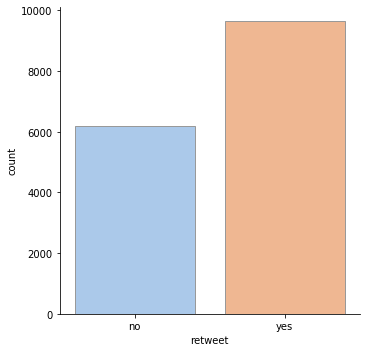

time: 182 ms


In [25]:
#Bar graph of number of rewteets
sns.catplot(x = "retweet", kind = "count", edgecolor = ".6",palette = "pastel",
            data = df_with_metadata);

valuecounts = df_with_metadata['retweet'].value_counts()

# Print percentage of each value
print('Yes: ', round(valuecounts[0]/
                     len(df_with_metadata['retweet'])*100,2),'%')
print('No: ', round(valuecounts[1]/
                    len(df_with_metadata['retweet'])*100,2),'%')


Just over 60% of these tweets are Retweets! There might be some duplicate tweets. We explore by taking a look at the top 10 most retweeted tweets and how many times they were retweeted.

In [26]:
#View the top 10 retweeted tweets
df_rt_counts = pd.DataFrame(df_with_metadata['message']
                            .astype(str).value_counts())
df_rt_counts.head(10)


message
RT @StephenSchlegel: she's thinking about how s...      307
RT @SenSanders: We have a president-elect who d...      130
RT @NatGeoChannel: Watch #BeforeTheFlood right ...       73
RT @BernieSanders: #ImVotingBecause the future ...       59
RT @SethMacFarlane: HRC proposes installing hal...       56
RT @BernieSanders: 'The concept of global warmi...       44
RT @SenSanders: We have a president-elect who d...       35
RT @CNN: No snow where there should be. Bleache...       33
RT @ddlovato: #IVotedBecause I believe in equal...       32
RT @SenSanders: If we don't address climate cha...       24

time: 19 ms


We have alot of the same tweet occurences so we would assume that the sentiment would be the same for each of them. Let's look at the top duplicate tweet to confirm this.

In [27]:
#View sentiment of tweet with the highest retweet count
df_most_duplicated_tweet = pd.DataFrame(df_with_metadata[df_with_metadata['message'] == "RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoN√É¬¢√¢‚Äö¬¨√Ç¬¶"])

df_most_duplicated_tweet[['message','sentiment']]


message  sentiment
10     RT @StephenSchlegel: she's thinking about how ...          1
51     RT @StephenSchlegel: she's thinking about how ...          1
98     RT @StephenSchlegel: she's thinking about how ...          1
122    RT @StephenSchlegel: she's thinking about how ...          1
142    RT @StephenSchlegel: she's thinking about how ...          1
...                                                  ...        ...
15652  RT @StephenSchlegel: she's thinking about how ...          1
15707  RT @StephenSchlegel: she's thinking about how ...          1
15716  RT @StephenSchlegel: she's thinking about how ...          1
15781  RT @StephenSchlegel: she's thinking about how ...          1
15811  RT @StephenSchlegel: she's thinking about how ...          1

[307 rows x 2 columns]

time: 12 ms


There are quite a couple of duplicate tweets with the same sentiment. This might be a problem and lead to over importance of certain categories.
 
There is also a recurrence of the following special character combination: '√É¬¢√¢‚Äö¬¨√Ç¬¶'. Let's Remove duplicates and this special character set before we continue.


In [28]:
# View shape of metadata_df
df_with_metadata.shape


(15819, 14)

time: 2 ms


In [29]:
# Removing special character combinations
df_with_metadata['message'] = [re.sub('√É¬¢√¢‚Äö¬¨√Ç¬¶', '', i)
                               for i in df_with_metadata['message']]

print(df_with_metadata['message'][10])


RT @StephenSchlegel: she's thinking about how she's going to die because your husband doesn't believe in climate change https://t.co/SjoFoN
time: 21 ms


In [30]:
# Drop duplicated retweeted tweets
df_with_metadata.drop_duplicates(subset = "message", 
                     keep = False, inplace = True) 

# View shape of metadata_df with duplicated removed
print(df_with_metadata.shape)


(13911, 14)
time: 18.9 ms


In [31]:
# View df with metadata again
df_with_metadata.head()


sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       message_token retweet         hashtags  \
0  [PolySciMajor, EPA, chief, does, n't, think, c...      no              NaN   
1  [It, 's, not, like, we, lack, evidence, of, an...      no              NaN   
2  [RT, @, RawStory, :, Researchers, say, we, hav...     yes              NaN   
3  [#, TodayinMaker, #, WIRED, :, 2016, was, a, p...      no   [TodayinMaker]   
4  [RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...     yes  [ElectionNight]   

   hashtag_count           mentions  mention_count  char_count  word_count  \
0              0         [mashable]              1         140          19   
1              0                NaN              0          62          10   
2              0         [RawStory]              1         140          19   
3              1                NaN              0          99          15   
4              1  [SoyNovioDeTodas]              1         122          18   

   avg_word_length  stopword_count  \
0             6.42               3   
1             5.30               3   
2             6.42               8   
3             5.67               5   
4             5.83               5   

                                        cleaned_text  
0  [polyscimajor, epa, chief, does not, think, ca...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [rt, @rawstory, researcher, year, act, climate...  
3  [#todayinmaker, wire, pivotal, year, war, clim...  
4  [rt, @soynoviodetodas, racist, sexist, climate...

time: 16 ms


### Hashtags and Mentions

We can tell a lot from the sentiment of tweets by looking at the hashtags which are used. Which hashtags appear the most in these tweets?

Word cloud of top hashtags


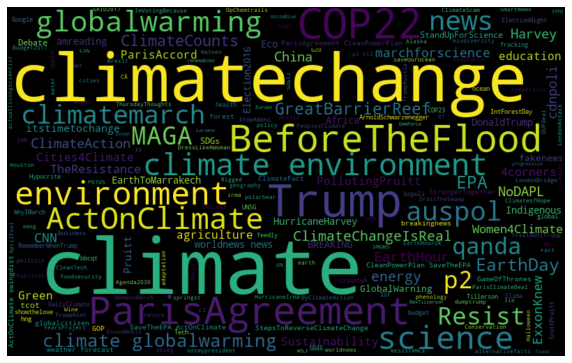

time: 1.21 s


In [32]:
# Drop null values from hashtags column
df_hashtags = df_with_metadata['hashtags'].dropna()

# Join all the text in the list and remove apostrophes
all_words_hastags = ' '.join([text for text in df_hashtags.astype(str)])
all_words_hastags = all_words_hastags.replace("'", "")

# Create word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21,
                      max_font_size = 110).generate(all_words_hastags)

# Plot word cloud
print('Word cloud of top hashtags')
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()


Looking at popular hashtags across all categories its seems as though the prominent hashtags include: 'Climatechange','climate','ActOnClimate'
These are to be expected as this dataset are tweets related to climate change.

Other prominent hashtags include: 'Paris Agreement', 'Trump','MAGA' etc. *This makes it seem as though these tweets are **American** and are **politically related**.*

The appearance of the hashtags 'Election night' and 'I'm Voting Because' also makes it seem as though these tweets were **sampled from twitter during the 2016 American presidential election.**

Let's have a look at mentions to confirm our hypothesis:

Word cloud of top mentions


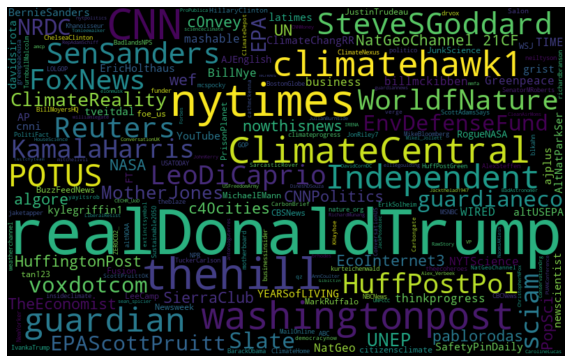

time: 1.42 s


In [33]:
# Drop null values from mentions column
df_mentions = df_with_metadata['mentions'].dropna()

# Join all the text in the list and remove apostrophes
all_words_mentions = ' '.join([text for text in df_mentions.astype(str)])
all_words_mentions = all_words_mentions.replace("'", "")

# Create word cloud
wordcloud = WordCloud(width = 800, height = 500, random_state = 21,
                    max_font_size = 110).generate(all_words_mentions)

# Plot word cloud
print('Word cloud of top mentions')
plt.figure(figsize = (10, 7))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()


There is a much wider spread of mentions with DonalTrump topping the list. The mentions which are prominent include : **'realDonaldTrump', 'POTUS', 'SenSanders', 'CNN'** etc. Which also makes it seem as though these tweets were taking during the election time.
One has to be cautious when analyzing mentions as there are two types of main mentions on Twitter :

1) **Where a twitter profile is referred to**

2) **Where a twitter profile Retweets something**

Since a mention occurs every time a tweet is retweeted, it might be worth looking into the mentions of only the retweets if time had allowed.

Let's have a look at character count distribution for these tweets:


#### Character and word count

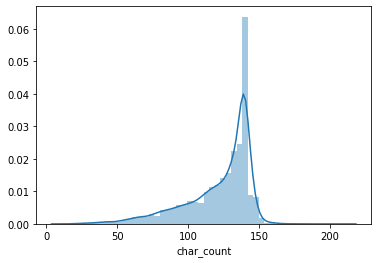

time: 239 ms


In [34]:
# Display distribution of total characters
sns.distplot(df_with_metadata['char_count'])


We can see from this plot that most of the tweets are using the full amount of characters allowed (140). We will see how these changes in each category. 

### EDA for categories

Let's dig a bit deeper into the tweets in each category to see if we can find out the reason they were classified in this manner as well as seeing if we can identify any similarities.

We start by separating the dataframes to analyze each category and looking at the most common mentions and hashtags.

In [35]:
# Create dataframes for each category
df_negative_tweets = df_with_metadata[df['sentiment'] == -1]
df_neutral_tweets = df_with_metadata[df['sentiment'] == 0]
df_positive_tweets = df_with_metadata[df['sentiment'] == 1]
df_news_tweets = df_with_metadata[df['sentiment'] == 2]
df_negative_tweets.head()


sentiment                                            message  tweetid  \
28         -1  Sally Kohn‚Äôs latest evidence of climate change...   355491   
46         -1  @realDonaldTrump Carbon Tax is a Globalist ide...    61141   
48         -1  RT @SteveSGoddard: We had winds close to 100 M...   719523   
56         -1  @MissLizzyNJ lmao üòÇ snowflakes ‚ùÑÔ∏è complaining ...   911385   
57         -1  RT @Dawn2334Dawn: This is ONE of Arnold Schwar...   768263   

                                        message_token retweet hashtags  \
28  [Sally, Kohn, ‚Äô, s, latest, evidence, of, clim...      no      NaN   
46  [@, realDonaldTrump, Carbon, Tax, is, a, Globa...      no      NaN   
48  [RT, @, SteveSGoddard, :, We, had, winds, clos...     yes      NaN   
56  [@, MissLizzyNJ, lmao, üòÇ, snowflakes, ‚ùÑÔ∏è, comp...      no      NaN   
57  [RT, @, Dawn2334Dawn, :, This, is, ONE, of, Ar...     yes      NaN   

    hashtag_count           mentions  mention_count  char_count  word_count  \
28              0      [twitchyteam]              1         139          21   
46              0  [realDonaldTrump]              1         137          21   
48              0    [SteveSGoddard]              1         136          24   
56              0      [MissLizzyNJ]              1          96          14   
57              0     [Dawn2334Dawn]              1         140          21   

    avg_word_length  stopword_count  \
28             5.67               8   
46             5.57               8   
48             4.67               9   
56             5.93               2   
57             5.71               7   

                                         cleaned_text  
28  [sally, kohn, late, evidence, climate, change,...  
46  [@realdonaldtrump, carbon, tax, globalist, ide...  
48  [rt, @stevesgoddard, wind, close, mph, area, a...  
56  [@misslizzynj, lmao, üòÇ, snowflakes, ‚ùÑ, Ô∏è, comp...  
57  [rt, @dawndawn, arnold, schwarzenegger's, vehi...

time: 24.8 ms


#### Most common mentions
We look at the most common mentions per category.

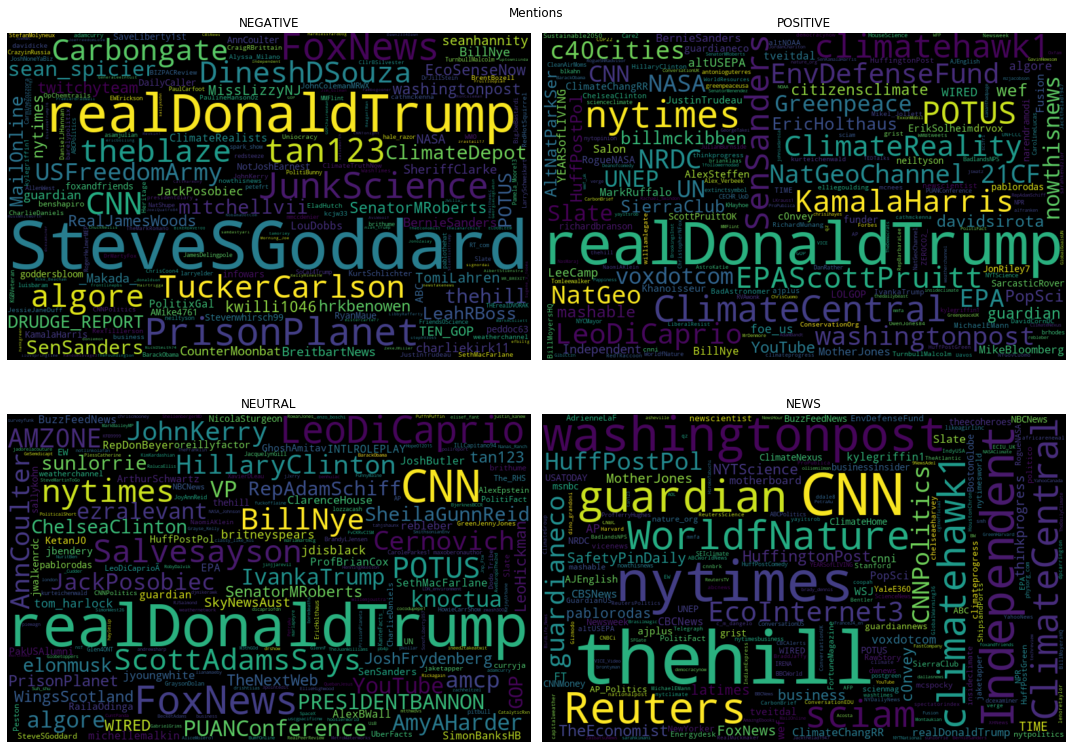

time: 5.48 s


In [36]:
# Drop null values from mentions column in negative tweets
df_neg_mentions = df_negative_tweets['mentions'].dropna()

# Join all the text in the list and remove apostrophes
all_words_mentions_neg = ' '.join([text for text in df_neg_mentions.astype(str)])
all_words_mentions_neg = all_words_mentions_neg.replace("'", "")

# Create word cloud
wordcloud1 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_mentions_neg)




# Drop null values from mentions column in neutral tweets
df_neut_mentions = df_neutral_tweets['mentions'].dropna()

# Join all the text in the list and remove apostrophes
all_words_mentions_neut = ' '.join([text for text in df_neut_mentions.astype(str)])
all_words_mentions_neut = all_words_mentions_neut.replace("'", "")

# Create word cloud
wordcloud2 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_mentions_neut)



# Drop null values from mentions column in positive tweets
df_pos_mentions = df_positive_tweets['mentions'].dropna()

# Join all the text in the list and remove apostrophes
all_words_mentions_pos = ' '.join([text for text in df_pos_mentions.astype(str)])
all_words_mentions_pos = all_words_mentions_pos.replace("'","")

# Create word cloud
wordcloud3 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_mentions_pos)



# Drop null values from mentions column in news tweets
df_news_mentions = df_news_tweets['mentions'].dropna()

# Join all the text in the list and remove apostrophes
all_words_mentions_news = ' '.join([text for text in df_news_mentions.astype(str)])
all_words_mentions_news = all_words_mentions_news.replace("'","")

# Create word cloud
wordcloud4 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_mentions_news)



# Plot all 4 word clouds to compare
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 11))
fig.suptitle('Mentions')

# Negative mention word cloud
axes[0,0].imshow(wordcloud1, interpolation = "bilinear")
axes[0,0].axis('off')
axes[0,0].set_title('NEGATIVE')

# Neutral mention word cloud
axes[1,0].imshow(wordcloud2, interpolation = "bilinear")
axes[1,0].axis('off')
axes[1,0].set_title('NEUTRAL')

# Positive mention word cloud
axes[0,1].imshow(wordcloud3, interpolation = "bilinear")
axes[0,1].axis('off')
axes[0,1].set_title('POSITIVE')

# News mention word cloud
axes[1,1].imshow(wordcloud4, interpolation = "bilinear")
axes[1,1].axis('off')
axes[1,1].set_title('NEWS')
fig.tight_layout()


#### Most common hastags
Now we look at the most common hashtags per category.

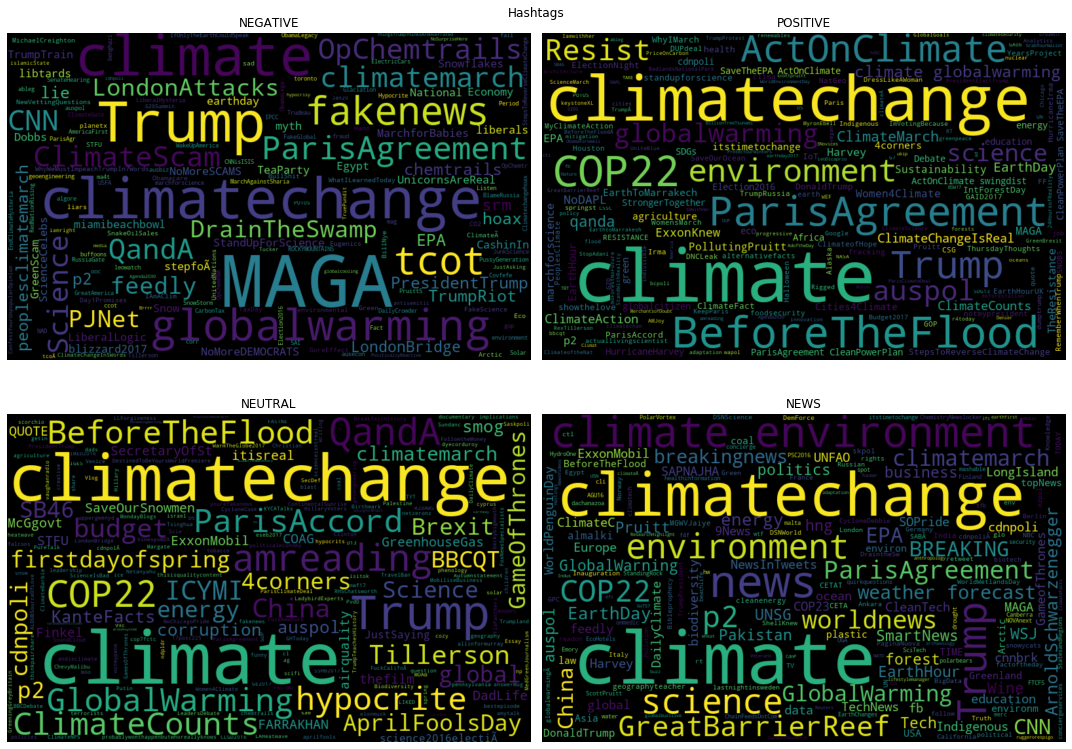

time: 4.82 s


In [37]:
# Drop null values from hastags column in negative tweets
df_neg_hashtags = df_negative_tweets['hashtags'].dropna()

# Join all the text in the list and remove apostrophes
all_words_hashtags_neg = ' '.join([text for text in df_neg_hashtags.astype(str)])
all_words_hashtags_neg = all_words_hashtags_neg.replace("'", "")

#Create word cloud
wordcloud1 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_hashtags_neg)



# Drop null values from hastags column in neutral tweets
df_neut_hashtags = df_neutral_tweets['hashtags'].dropna()

# Join all the text in the list and remove apostrophes
all_words_hashtags_neut = ' '.join([text for text in df_neut_hashtags.astype(str)])
all_words_hashtags_neut = all_words_hashtags_neut.replace("'", "")

# Create word cloud
wordcloud2 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_hashtags_neut)



# Drop null values from hastags column in postive tweets
df_pos_hashtags = df_positive_tweets['hashtags'].dropna()

# Join all the text in the list and remove apostrophes
all_words_hashtags_pos = ' '.join([text for text in df_pos_hashtags.astype(str)])
all_words_hashtags_pos = all_words_hashtags_pos.replace("'", "")

#Create word cloud
wordcloud3 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_hashtags_pos)



# Drop null values from hastags column in news tweets
df_news_hashtags = df_news_tweets['hashtags'].dropna()

# Join all the text in the list and remove apostrophes
all_words_hashtags_news = ' '.join([text for text in df_news_hashtags.astype(str)])
all_words_hashtags_news = all_words_hashtags_news.replace("'", "")

# Create word cloud
wordcloud4 = WordCloud(width = 800, height = 500, random_state = 21,
                       max_font_size = 110).generate(all_words_hashtags_news)



# Plot all 4 word clouds to compare
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 11))
fig.suptitle('Hashtags')

# Negative hashtag word cloud
axes[0,0].imshow(wordcloud1, interpolation = "bilinear")
axes[0,0].axis('off')
axes[0,0].set_title('NEGATIVE')

# Neutral hashtag word cloud
axes[1,0].imshow(wordcloud2, interpolation = "bilinear")
axes[1,0].axis('off')
axes[1,0].set_title('NEUTRAL')

# Positive hashtag word cloud
axes[0,1].imshow(wordcloud3, interpolation = "bilinear")
axes[0,1].axis('off')
axes[0,1].set_title('POSITIVE')

# News hashtag word cloud
axes[1,1].imshow(wordcloud4, interpolation = "bilinear")
axes[1,1].axis('off')
axes[1,1].set_title('NEWS')
fig.tight_layout()


#### Most Important Words

Let's put together a dataframe of the top words, hashtags and mentions so that we can see what words are influencing each category.

In [38]:
# Word frequency function
def word_freq(clean_text_list, top_n):
    '''
    This function returns a dataframe with the most common words
    in the text and the count of their frequency. It takes in a
    list of clean text, and top n frequency.
    '''
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


time: 999 ¬µs


In [39]:
# # add borders to dataframes
# %%HTML
# <style type="text/css">
# table.dataframe td, table.dataframe th {
#     border: 1px  black solid !important;
#   color: black !important;
# }
# </style>

time: 1 ms


In [40]:
# Use word_freq function to retrieve the most common words

# Top 20 most frequent words
topn = 20

# Word frequency of all sentiments
all_words_list = df_with_metadata['cleaned_text'].tolist()
all_top = word_freq(all_words_list, topn)

# Word frequency of negative sentiments
neg_words_list = df_negative_tweets['cleaned_text'].tolist()
neg_top = word_freq(neg_words_list, topn)

# Word frequency of neutral sentiments
neut_words_list = df_neutral_tweets['cleaned_text'].tolist()
neut_top = word_freq(neut_words_list, topn)

# Word frequency of positive sentiments
pos_words_list = df_positive_tweets['cleaned_text'].tolist()
pos_top = word_freq(pos_words_list, topn)

# Word frequency of news sentiments
news_words_list = df_news_tweets['cleaned_text'].tolist()
news_top = word_freq(news_words_list, topn)

# Create new dataframe from the top words
df_top = pd.concat([all_top,neg_top, neut_top, pos_top, news_top], axis = 1)
cols = ['All','Count','Negative', 'Count', 'Neutral',
        'Count', 'Positive', 'Count', 'News', 'Count']
df_top.columns = cols

# Return dataframe with top words
df_top


All  Count   Negative Count  Neutral Count Positive Count  \
0      change  11135    climate   759  climate  1354   change  5928   
1     climate  11075     change   744   change  1345  climate  5881   
2          rt   7819         rt   594   global   958       rt  4279   
3      global   3393     global   577       rt   947   global  1372   
4     warming   2556    warming   458  warming   755  warming  1029   
5       trump   1626       warm   106     warm   188    trump   659   
6           ‚Äö    984       make    88        ‚Äö   165        ‚Äö   598   
7           ¬¨    954    science    75        ¬¨   162        ¬¨   581   
8     believe    701      cause    69        ÔøΩ   123  believe   526   
9        warm    666       just    68    trump   118     real   447   
10          ¬¶    663  scientist    63        ¬¶   115        ¬¶   430   
11       real    643          ÔøΩ    62    cause   111    fight   356   
12       just    585       real    60     like   101     just   349   
13      fight    575    believe    59     real    99    think   346   
14      think    526        man    55    think    99   denier   327   
15        epa    522       year    55     just    94   people   325   
16  scientist    499      trump    54  believe    88     like   269   
17      cause    482       scam    52     talk    68    world   260   
18        new    477       hoax    50     make    66     warm   259   
19       make    474       data    50     know    65     deny   258   

         News Count  
0      change  3118  
1     climate  3081  
2          rt  1999  
3       trump   795  
4      global   486  
5     warming   314  
6         epa   247  
7   scientist   209  
8         new   188  
9       fight   176  
10          ‚Äö   172  
11          ¬¨   162  
12    trump's   155  
13     donald   141  
14   #climate   129  
15      world   125  
16      china   120  
17       warm   113  
18      scott   112  
19          ‚Äò   108

time: 124 ms


As we can see :

- for all words : **'climate', 'change','rt', 'global',and 'warming'** all are at the top of the word counts. These are top   occurences throughout all categories.

- for negative words : **'science', 'cause','real', and 'scam'** stand out as top words that are distinct to negative.

- for news words : **'fight', 'epa','pruit', 'scientist',and 'new'** stand out as top words that are distinct to news.

How we address these words in our model is important as they could carry importance in different categories as well as influence predictions.

We can see that the positive sentiment has a higher number of occurences for top words due to the imbalance of positive tweets.


#### Most Important Hashtags

In [41]:
# Use word_freq function to retrieve the most common hastags

# Top 20 most common hashtags
topn = 20

# Hashtag frequency of all sentiments
all_words_list_hashtags = df_with_metadata['hashtags'].dropna().tolist()
all_top_hashtags = word_freq(all_words_list_hashtags, topn)

# Hashtag frequency of negative sentiments
neg_words_list_hashtags = df_negative_tweets['hashtags'].dropna().tolist()
neg_top_hashtags = word_freq(neg_words_list_hashtags, topn)

# Hashtag frequency of neutral sentiments
neut_words_list_hashtags = df_neutral_tweets['hashtags'].dropna().tolist()
neut_top_hashtags = word_freq(neut_words_list_hashtags, topn)

# Hashtag frequency of positive sentiments
pos_words_list_hashtags = df_positive_tweets['hashtags'].dropna().tolist()
pos_top_hashtags = word_freq(pos_words_list_hashtags, topn)

# Hashtag frequency of news sentiments
news_words_list_hashtags = df_news_tweets['hashtags'].dropna().tolist()
news_top_hashtags = word_freq(news_words_list_hashtags, topn)

# Create new dataframe from the top hashtags
df_top = pd.concat([all_top_hashtags,neg_top_hashtags,neut_top_hashtags,
                    pos_top_hashtags, news_top_hashtags], axis = 1)
cols = ['All','Count','Negative', 'Count', 'Neutral',
        'Count', 'Positive', 'Count', 'News', 'Count']
df_top.columns = cols

# Return dataframe with top hashtags
df_top


All Count        Negative Count           Neutral Count  \
0            climate   330            MAGA    11           climate    16   
1      climatechange   153         climate     8     climatechange    11   
2              Trump    70           Trump     7             Trump     6   
3        environment    68   climatechange     6     ClimateChange     4   
4              COP22    63            tcot     4         amreading     4   
5     ParisAgreement    60  ParisAgreement     4             QandA     3   
6      ClimateChange    41        fakenews     3       ParisAccord     3   
7     BeforeTheFlood    41           QandA     3             COP22     3   
8       ActOnClimate    38     ClimateScam     3         Tillerson     2   
9      globalwarming    31    OpChemtrails     3             ICYMI     2   
10           science    27             CNN     3             China     2   
11                p2    26    climatemarch     3  firstdayofspring     2   
12            auspol    25   globalwarming     3     GlobalWarming     2   
13              news    21   DrainTheSwamp     2     AprilFoolsDay     2   
14              MAGA    20            maga     2              SB46     2   
15      climatemarch    18   ClimateChange     2            energy     2   
16     GlobalWarming    18   LondonAttacks     2     GameOfThrones     2   
17               EPA    16           PJNet     2     ClimateCounts     2   
18          EarthDay    14          feedly     2          4corners     2   
19  GreatBarrierReef    13  PresidentTrump     2            Brexit     2   

          Positive Count              News Count  
0          climate   182           climate   124  
1    climatechange    94       environment    44  
2            COP22    47     climatechange    42  
3   ParisAgreement    46             Trump    25  
4     ActOnClimate    38              news    20  
5   BeforeTheFlood    37                p2    14  
6            Trump    32             COP22    13  
7    globalwarming    25           science    13  
8    ClimateChange    23     ClimateChange    12  
9      environment    23  GreatBarrierReef    11  
10          auspol    19              News    10  
11         science    12    ParisAgreement     9  
12          Resist    11      climatemarch     7  
13           qanda    11     CLIMATEchange     6  
14          resist    10             China     6  
15        EarthDay     9     Climatechange     5  
16       ExxonKnew     9     GlobalWarming     5  
17          NoDAPL     9               CNN     5  
18   ClimateAction     9           weather     5  
19   GlobalWarming     9          forecast     5

time: 37 ms


It looks like there are not many repetative hashtags being used in the Negative and the Neutral tweets (probably due to them having the lowest number of samples in the dataset)

News and Positive on the other hand have quite a few repeat hashtags. These top hashtags could be used as heavier weighted predictors. Specifically for news.

#### Most Important Mentions

In [42]:
# Use word_freq function to retrieve the most common mentions

# Top 20 most common mentions
topn = 20

# Mention frequency of all sentiments
all_words_list_mentions = df_with_metadata['mentions'].dropna().tolist()
all_top_mentions = word_freq(all_words_list_mentions, topn)

# Mention frequency of negative sentiments
neg_words_list_mentions = df_negative_tweets['mentions'].dropna().tolist()
neg_top_mentions = word_freq(neg_words_list_mentions, topn)

# Mention frequency of neutral sentiments
neut_words_list_mentions = df_neutral_tweets['mentions'].dropna().tolist()
neut_top_mentions = word_freq(neut_words_list_mentions, topn)

# Mention frequency of positive sentiments
pos_words_list_mentions = df_positive_tweets['mentions'].dropna().tolist()
pos_top_mentions = word_freq(pos_words_list_mentions, topn)

# Mention frequency of news sentiments
news_words_list_mentions = df_news_tweets['mentions'].dropna().tolist()
news_top_mentions = word_freq(news_words_list_mentions, topn)

# Create new dataframe from the top hashtags
df_top = pd.concat([all_top_mentions,neg_top_mentions, neut_top_mentions,
                    pos_top_mentions, news_top_mentions], axis = 1)
cols = ['All','Count','Negative', 'Count', 'Neutral',
        'Count', 'Positive', 'Count', 'News', 'Count']
df_top.columns = cols

# Return dataframe with top hashtags
df_top


All Count         Negative Count          Neutral Count  \
0   realDonaldTrump   220    SteveSGoddard    42  realDonaldTrump    23   
1           nytimes    97  realDonaldTrump    24              CNN    12   
2           thehill    90     PrisonPlanet    11          FoxNews     9   
3               CNN    86          FoxNews    11      LeoDiCaprio     7   
4    washingtonpost    71      JunkScience    10      Salvesayson     6   
5    ClimateCentral    62           tan123     9          nytimes     6   
6      climatehawk1    61    TuckerCarlson     8          BillNye     5   
7       Independent    52              CNN     8   ScottAdamsSays     5   
8          guardian    49         theblaze     8        Cernovich     4   
9     SteveSGoddard    44       Carbongate     7           AMZ0NE     4   
10            POTUS    43     DineshDSouza     7       AnnCoulter     4   
11       SenSanders    42    USFreedomArmy     7   HillaryClinton     4   
12          Reuters    37     sean_spicier     7        JohnKerry     4   
13     WorldfNature    37     ClimateDepot     7               VP     3   
14          FoxNews    36       SenSanders     7     JackPosobiec     3   
15      LeoDiCaprio    36           algore     7             amcp     3   
16      HuffPostPol    35      mitchellvii     7       AmyAHarder     3   
17     KamalaHarris    32            POTUS     6            POTUS     3   
18            sciam    32       MailOnline     6      IvankaTrump     3   
19      guardianeco    31        LeahRBoss     6       ezralevant     3   

           Positive Count            News Count  
0   realDonaldTrump   163         thehill    77  
1           nytimes    42             CNN    48  
2    ClimateCentral    37         nytimes    44  
3      climatehawk1    33  washingtonpost    42  
4        SenSanders    33     Independent    38  
5       LeoDiCaprio    28         Reuters    34  
6             POTUS    28        guardian    32  
7      KamalaHarris    28    WorldfNature    29  
8     NatGeoChannel    28    climatehawk1    27  
9    EPAScottPruitt    27           sciam    25  
10   ClimateReality    26  ClimateCentral    24  
11   EnvDefenseFund    24    EcoInternet3    23  
12   washingtonpost    23     guardianeco    21  
13             NRDC    23     HuffPostPol    18  
14             21CF    22     CNNPolitics    18  
15              EPA    21  HuffingtonPost    17  
16        c40cities    20    TheEconomist    17  
17             NASA    20          c0nvey    16  
18           NatGeo    19  SafetyPinDaily    15  
19               UN    19        business    15

time: 49 ms


From our research - most of these mentions occur in the retweets. Similar to the hashtags, the negative and neutral tweets have low mention ocurrences. It would be a good idea to put importance of these mentions as there are high occurence of certain mentions in different categories. Notably :

- @realDonaldTrump at the top of the positive list - probably due to alot of tweets being directed towards him
- @thehill and @CNN at the top of the News list which is to be expected and could be used for predictions



### EDA Summary 
Let's summarise a few key points of what we have found so far:

1) About 60% of these tweets are positive towards climate change - This indicates an imbalanced training dataset.

2) This data seems to be taken from Americans around the time of the 2016 US presidential elections.

3) @realDonaldTrump is the top mentioned account 

4) 'Climatechange', 'climate', and 'Trump' are the three most used hashtags

5) The full character limit of 140 characters was used in the majority of these tweets.

6) Retweets create duplicate data points in the dataset

7) Top organisations include renowned climate change activists which could be useful from a business networking perspective

# 8. Balancing dataset <a name="balance"></a>

[Return to top](#top) <br><br>

Unbalanced datasets are characterized by one class in the data set outnumbering the other classes in the data. 

This is important as machine learning models are accuracy driven. This means that models will try to reduce the error even at the cost of the minority classes. As a result models will tend to see the error as carrying the same cost across all classes in the dataset. That's why balancing our data is important. 

We have chosen three types of sampling to try:

1) Downsample majority classes<br>
2) Upsample minority classes<br>
3) Downsampling majority classes and Upsampling minority classes
 

But first, lets start by looking at our data in order to see what classes will be affected


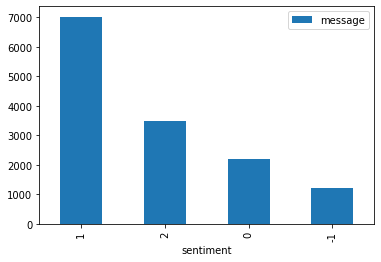

time: 173 ms


In [43]:
# plot by sentimental classes
sentiment_class_count = df_with_metadata[['sentiment',
                                          'message']].groupby('sentiment').count()

sentiment_class_count.sort_values('message', ascending=False).plot(kind='bar')
plt.show()


In [44]:
# View dataframe with count of sentiments
df_with_metadata[['sentiment', 'message']].groupby('sentiment').count()


message
sentiment         
-1            1204
 0            2203
 1            7015
 2            3489

time: 8.98 ms


As we can see from this overview, the data is heavily imbalanced in favour of the pro(1) class.

Knowing this allows us to safely assume that unless the model used is robust, the model will most likely have a hard time identifying our minority classes on unseen data. To fix this we can try downsampling


#### Downsample

To downsample our data we need to get the count of our minority class. This tells us the size we should aim for across our dataset. We then only choose enough random observations across our major classes to achieve a balanced dataset.

Lets see this in action:

In [45]:
# Create a dataframe for each sentiment
pro = df_with_metadata[df_with_metadata['sentiment'] == 1]
news = df_with_metadata[df_with_metadata['sentiment'] == 2]
neutral = df_with_metadata[df_with_metadata['sentiment'] == 0]
anti = df_with_metadata[df_with_metadata['sentiment'] == -1]


time: 9.01 ms


In [46]:
# Downsampling all classes to meet the minority class count - 1204
class_size_down = int(len(df_with_metadata[df_with_metadata['sentiment' ] == -1]))
print('Downsamplng class size:', class_size_down)


Downsamplng class size: 1204
time: 4.99 ms


In [47]:
# Downsampling all classes to meet the minority class count - 1204

#Downsample pro - sentiment = 1
pro_downsampled = resample(pro,
                          replace = False, # Sample without replacement
                          n_samples = class_size_down, # Match minority class
                          random_state = 27) # Reproducible results

#Downsample news - sentiment = 2
news_downsampled = resample(news,
                          replace = False, # Sample without replacement
                          n_samples = class_size_down, # Match minority class
                          random_state = 27) # Reproducible results

#Downsample neutral - sentiment = 0
neutral_downsampled = resample(neutral,
                          replace = False, # Sample without replacement
                          n_samples = class_size_down, # Match minority class
                          random_state = 27) # Reproducible results

# Combine downsampled majority class with minority class
downsampled = pd.concat([pro_downsampled, news_downsampled,
                         neutral_downsampled, anti])

# Check new class counts
print(downsampled['sentiment'].value_counts())


-1    1204
 2    1204
 1    1204
 0    1204
Name: sentiment, dtype: int64
time: 18 ms


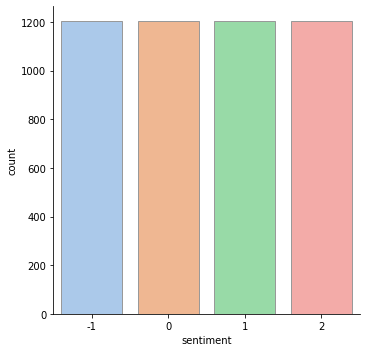

time: 194 ms


In [48]:
#Bar graph of balanced sentiment count
sns.catplot(x = "sentiment", kind = "count", edgecolor = ".6",
            palette = "pastel",data = downsampled);


As we can see our data has been balanced across the dataset. However there is a problem, because of the discrepancy in size between the classes we run the risk of losing valuable information in our downsampled classes. 

There is another option we can chose from to fix this balancing issue.

#### Upsampling

There is another option we can choose if we are afraid of losing some of the lexicon offered by our majority classes.

Upsampling can be considered the inverse of downsampling. In this case we return the count of our majority class and "upsample" the minority classes to this count. To do this we randomly repeat observations across our minority classes to pad the difference.

Lets see this in action:


In [49]:
# Upsampling- class size is the size of the majority pro(1) class
class_size_up = int(len(df_with_metadata[df_with_metadata['sentiment'] == 1]))
print('Upsampling class size:', class_size_up)


Upsampling class size: 7015
time: 7 ms


In [50]:
# Upsampling minority of all classes to meet the majority class count - 8530

#Upsample news - sentiment = 2
news_upsampled = resample(news,
                          replace = True, # sample without replacement
                          n_samples = class_size_up, # match majority class
                          random_state=27) # reproducible results

#Upsample neutral - sentiment = 0
neutral_upsampled = resample(neutral,
                          replace = True, # sample without replacement=
                          n_samples = class_size_up, # match majority class
                          random_state=27) # reproducible results

#Upsample anti - sentiment = -1
anti_upsampled = resample(anti,
                          replace = True, # sample without replacement
                          n_samples = class_size_up, # match majority class
                          random_state=27) # reproducible results


# Combine upsampled minority classes with majority class
upsampled = pd.concat([pro, news_upsampled,
                       neutral_upsampled, anti_upsampled])

# Check new class counts
print(upsampled['sentiment'].value_counts())


-1    7015
 2    7015
 1    7015
 0    7015
Name: sentiment, dtype: int64
time: 22 ms


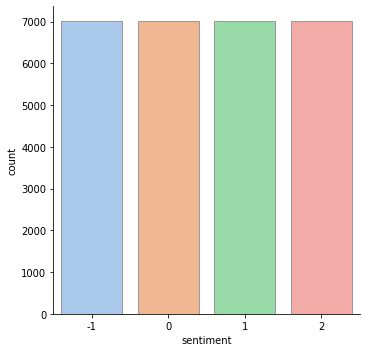

time: 215 ms


In [51]:
#Bar graph of balanced sentiment count
sns.catplot(x = "sentiment", kind = "count", edgecolor = ".6",
            palette = "pastel",data = upsampled);


#### Upsampling minority and downsampling majority

As alluded above, as much as  both upsampling and downsampling balance our dataset they come up with other problems. With downsampling we risk losing most of our dataset therefore losing valuable information from the classes that will be downsampled. With upsampling we risk creating a lot of noise in our data since we creating duplicates of the minority classes. Using upsampling means we will have more data of the same observations.

Upsampling minority class and downsampling majoriy class is the best of both the above balancing techniques as it finds the middle ground between the two approaches. In order for this approach to work, the class size has to be a value between minority class and majority class size. The class size is set as half the size of the majority class.

Lets see this in action:

In [52]:
# Midsampling - class size is 50% of the majority pro(1) class
class_size_mid = int(len(df_with_metadata[df_with_metadata['sentiment'] == 1])/2)
print('Upsampling and downsampling class size:', class_size_mid )


Upsampling and downsampling class size: 3507
time: 4 ms


In [53]:
# Upsampling minority classes and downsampling majority classes - 4265

# Downsample pro - sentiment = 1
pro_downsampled = resample(pro,
                          replace = False, # sample without replacement
                          n_samples = class_size_mid, # half  majority class
                          random_state = 27) # reproducible results

# Upsample anti - sentiment = -1
anti_upsampled = resample(anti,
                          replace = True, # sample with replacement
                          n_samples = class_size_mid, # half of majority class
                          random_state = 27) # reproducible results

# Upsample news - sentiment=2
news_upsampled = resample(news,
                          replace = True, # sample with replacement
                          n_samples = class_size_mid, # half of majority class
                          random_state = 27) # reproducible results

#Upsample neutral - sentiment=0
neutral_upsampled = resample(neutral,
                          replace = True, # sample with replacement
                          n_samples = class_size_mid, # half of majority class
                          random_state = 27) # reproducible results

# Combine downsampled majority class with minority class
upsampled_downsampled = pd.concat([pro_downsampled, anti_upsampled,
                                   news_upsampled, neutral_upsampled])

# Check new class counts
print(upsampled_downsampled['sentiment'].value_counts())


-1    3507
 2    3507
 1    3507
 0    3507
Name: sentiment, dtype: int64
time: 23 ms


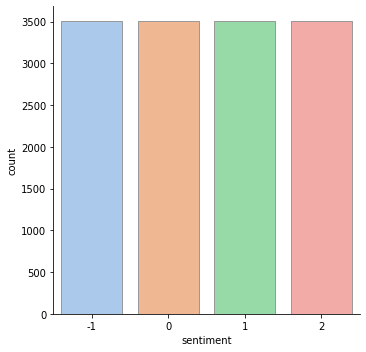

time: 307 ms


In [54]:
#Bar graph of balanced sentiment count
sns.catplot(x = "sentiment", kind = "count", edgecolor = ".6",
            palette = "pastel",data = upsampled_downsampled);


# 9. Base model <a name="base"></a>

[Return to top](#top) <br><br>

We run a selection of basic model through our raw data to get a benchmark of the f1 score that we will attempt to improve. The base models include:

- Logistic regression
- Linear SVC
- Gaussian Naive Bayes
- Decision tree
- Random forest

We run each of these models on a variety of combinations of text preprocessing and text cleaning methods and have concluded that we get the best results with the following cleaning methods:
- Lemmatize text
- Do not remove stop words
- Keep hashtags, mentions and retweets
- Vectorize text with TF-IDF vectorizer
- Normalise text using MaxAbsScaler()

Let's have another look at the information we have extracted from the data.

In [55]:
# Review metadata df
df_with_metadata.head()


sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

                                       message_token retweet         hashtags  \
0  [PolySciMajor, EPA, chief, does, n't, think, c...      no              NaN   
1  [It, 's, not, like, we, lack, evidence, of, an...      no              NaN   
2  [RT, @, RawStory, :, Researchers, say, we, hav...     yes              NaN   
3  [#, TodayinMaker, #, WIRED, :, 2016, was, a, p...      no   [TodayinMaker]   
4  [RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...     yes  [ElectionNight]   

   hashtag_count           mentions  mention_count  char_count  word_count  \
0              0         [mashable]              1         140          19   
1              0                NaN              0          62          10   
2              0         [RawStory]              1         140          19   
3              1                NaN              0          99          15   
4              1  [SoyNovioDeTodas]              1         122          18   

   avg_word_length  stopword_count  \
0             6.42               3   
1             5.30               3   
2             6.42               8   
3             5.67               5   
4             5.83               5   

                                        cleaned_text  
0  [polyscimajor, epa, chief, does not, think, ca...  
1  [like, lack, evidence, anthropogenic, global, ...  
2  [rt, @rawstory, researcher, year, act, climate...  
3  [#todayinmaker, wire, pivotal, year, war, clim...  
4  [rt, @soynoviodetodas, racist, sexist, climate...

time: 16 ms


In [56]:
# Create feature_df by filtering columns from metadata
feature_df = df_with_metadata.filter([
                    'sentiment','cleaned_text', 'retweet',
                    'hashtag_count', 'mention_count', 'char_count',
                    'word_count', 'avg_word_length', 'stopword_count'
                                     ], axis = 1)

# Replace yes and no with 1 and 0 in retweet columns
feature_df['retweet'] = feature_df['retweet'].map(dict(yes = 1, no = 0))

# String text together for vectorizer
feature_df['cleaned_text'] = feature_df['cleaned_text'].apply(lambda x:
                                                              ' '.join(word for word in x))

# View feature_df
feature_df.head()


sentiment                                       cleaned_text  retweet  \
0          1  polyscimajor epa chief does not think carbon d...        0   
1          1    like lack evidence anthropogenic global warming        0   
2          2  rt @rawstory researcher year act climate chang...        1   
3          1  #todayinmaker wire pivotal year war climate ch...        0   
4          1  rt @soynoviodetodas racist sexist climate chan...        1   

   hashtag_count  mention_count  char_count  word_count  avg_word_length  \
0              0              1         140          19             6.42   
1              0              0          62          10             5.30   
2              0              1         140          19             6.42   
3              1              0          99          15             5.67   
4              1              1         122          18             5.83   

   stopword_count  
0               3  
1               3  
2               8  
3               5  
4               5

time: 37.1 ms


#### Choosing Vectorizer

CountVectorizer vs TF-IDFVectorizer

CountVectorizer gives you a vector with the number of times each word appears in the document. This leads to a few problems mainly that common words like ‚Äúa‚Äù, ‚Äùthe‚Äù, ‚Äùand‚Äù, ‚Äùan‚Äù etc will appear most of the time and other words that carry the topic information of your document will be less frequent. For instance, if you‚Äôre training a classifier to identify documents related to AI you don‚Äôt want it to learn words like ‚Äúa‚Äù and ‚Äúthe‚Äù because they‚Äôll be in every single document (both related to AI and not related documents). Furthermore, the number of occurrences for these non-topic bearing terms will be significantly higher than any other term. This will force them to have the highest weight in the model simply due to their high occurrence and will skew your model.

The way to combat this problem is to use TF-IDF. What TF-IDF does is it balances out the term frequency (how often the word appears in the document) with its inverse document frequency (how often the term appears across all documents in the data set). This means that words like ‚Äúa‚Äù and ‚Äúthe‚Äù will have very low scores as they‚Äôll appear in all documents in your set. Rarer words like for instance ‚Äúmachine learning‚Äù will be very common in just a handful of documents which talk about computer science or AI. TF-IDF will give higher scores to these words and thus they‚Äôll be the ones that the model identifies as important and tries to learn.



In [57]:
#Vectorize text and keep addtional features with DataFrameMapper
data = feature_df

# Use TF-IDF vecotirzer on original 'message' text
mapper = DataFrameMapper([
     ('cleaned_text', TfidfVectorizer(min_df = 2, 
                                 max_df = 0.9,strip_accents='unicode',
                                 analyzer = 'word',
                                 ngram_range = (1, 2))),
     ('retweet', None),
     ('hashtag_count', None),
     ('mention_count', None),
     ('char_count', None),
     ('word_count', None),
     ('avg_word_length', None),
 ])

# X features
X = mapper.fit_transform(data)

# Y label
y = y = feature_df['sentiment']


time: 751 ms


In [58]:
# Split dataset with 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2,  
                                                    random_state = 27)


time: 2.97 s


In [59]:
# Use MaxAbsScaler() to normalise values
max_abs_scaler = preprocessing.MaxAbsScaler()

# Fit to and transform X_train
X_train = max_abs_scaler.fit_transform(X_train)  

# Transform X_test
X_test = max_abs_scaler.transform(X_test)


time: 5.27 s


In [60]:
# Names of base models
names = ['Logistic Regression',
         'Linear SVC', 'Gaussian Naive Bayes',          
         'Decision Tree', 'Random Forest']


time: 1e+03 ¬µs


In [61]:
# Classifiers models and some hyperparameters
classifiers = [
    LogisticRegression(max_iter = 200, multi_class = 'ovr', solver = 'lbfgs'), 
    LinearSVC(),
    GaussianNB(),
    DecisionTreeClassifier(max_depth = 5),
    RandomForestClassifier(max_depth = 5, n_estimators = 10,
                           max_features = 1)   
]


time: 4 ms


In [62]:
# Create empty lists and dictionaries
results = []

models = {}
confusion = {}
class_report = {}

# Iterate through names and classifiers list and fit models
for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    # Predictions
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    # Model accuracy
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average = 'weighted')
    recall    = metrics.recall_score(y_train, y_pred, average = 'weighted')
    
    f1        = metrics.f1_score(y_train, y_pred, average = 'weighted')    
    f1_test   = metrics.f1_score(y_test, y_pred_test, average = 'weighted')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall,
                    f1, f1_test, run_time.best])

# Create dataframe of results    
results = pd.DataFrame(results, columns = ['Classifier', 'Accuracy',
                                           'Precision', 'Recall', 'F1 Train',
                                           'F1 Test', 'Train Time'])

# Set index as 'Classifier'
results.set_index('Classifier', inplace = True)


Fitting Logistic Regression model...
... predicting
... scoring
Fitting Linear SVC model...
... predicting
... scoring
Fitting Gaussian Naive Bayes model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
time: 13min 23s


In [63]:
# Return dataframe of result sorted by f1 values
results.sort_values('F1 Train', ascending = False)


Accuracy  Precision    Recall  F1 Train   F1 Test  \
Classifier                                                                
Linear SVC            0.996136   0.996139  0.996136  0.996135  0.667324   
Logistic Regression   0.948508   0.949272  0.948508  0.947897  0.692631   
Gaussian Naive Bayes  0.921639   0.932052  0.921639  0.923255  0.595665   
Decision Tree         0.597771   0.625697  0.597771  0.549157  0.528775   
Random Forest         0.506111   0.256148  0.506111  0.340145  0.329945   

                      Train Time  
Classifier                        
Linear SVC              1.575879  
Logistic Regression    69.803753  
Gaussian Naive Bayes    4.413779  
Decision Tree          16.237675  
Random Forest           0.700442

time: 60 ms


We plot the result in a bar graph.

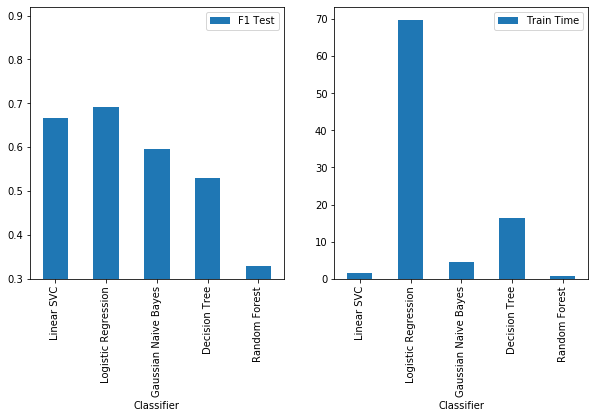

time: 397 ms


In [64]:
# Plot model results in graph for a more visual explaination
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
results.sort_values('F1 Train', ascending = False, inplace = True)
results.plot(y = ['F1 Test'], kind = 'bar', ax = ax[0],
             xlim = [0,1.1], ylim = [0.30,0.92])
results.plot(y = 'Train Time', kind = 'bar', ax = ax[1])


#### Cross Validation

We apply cross validation on the models to avoid overfitting our model to the data.

In [65]:
# This cell takes long to run - uncomment if necessary to run
'''
# Cross validation returning accurcy and standard deviation
cv = []
for name, model in models.items():
    print ()
    print(name)
    scores = cross_val_score(model, X, y, cv = 5)
    print("Accuracy: {:0.2f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])
    
cv = pd.DataFrame(cv, columns = ['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace = True)
'''

'\n# Cross validation returning accurcy and standard deviation\ncv = []\nfor name, model in models.items():\n    print ()\n    print(name)\n    scores = cross_val_score(model, X, y, cv = 5)\n    print("Accuracy: {:0.2f} (+/- {:0.4f})".format(scores.mean(), scores.std()))\n    cv.append([name, scores.mean(), scores.std() ])\n    \ncv = pd.DataFrame(cv, columns = [\'Model\', \'CV_Mean\', \'CV_Std_Dev\'])\ncv.set_index(\'Model\', inplace = True)\n'

time: 2.98 ms


In [67]:
'''
# Plot results from cross validation
cv.plot(y = 'CV_Mean', yerr = 'CV_Std_Dev',kind = 'bar', ylim = [0.65, 0.85])
'''

"\n# Plot results from cross validation\ncv.plot(y = 'CV_Mean', yerr = 'CV_Std_Dev',kind = 'bar', ylim = [0.65, 0.85])\n"

time: 2 ms


# 10. Model evaluation & optimisation<a name="evaluation"></a>

[Return to top](#top) <br><br>

From the cross validation results of the base models, we select the top performing models and run the models on our processed text and additional features. The best performing models include:
- SVC
- Logistic regression

#### Grid search and Cross Validation on best performing models

Grid-search is used to find the optimal hyperparameters of a model which results in the most ‚Äòaccurate‚Äô predictions.

A model hyperparameter is a characteristic of a model that is external to the model and whose value cannot be estimated from data. The value of the hyperparameter has to be set before the learning process begins. For example, c in Support Vector Machines, k in k-Nearest Neighbors, the number of hidden layers in Neural Networks.

Cross Validation is a very useful technique for assessing the effectiveness of your models, particularly in cases where you need to mitigate overfitting. It is also of use in determining the hyperparameters of your model, in the sense that which parameters will result in lowest test error. 

We will perform a grid search with cross validation on the top two most performing models so that we can optimize their results by finding the optimal hyperparameters of each model.

#### Grid search and cross validation on SVC

In [70]:
# Grid search and crossvalidation on SVC
nfolds = 3

Cs = [0.001, 0.01, 0.1, 1, 0,25, 10]

param_grid = {
    'C'     : Cs,
    }

grid_SVM = GridSearchCV(LinearSVC(), param_grid, scoring = 'f1_weighted', cv = nfolds)


time: 2 ms


In [71]:
# Fit optimised SVC
# This cell takes long to run - uncomment to run 
'''
grid_SVM.fit(X_train, y_train)
'''

'\ngrid_SVM.fit(X_train, y_train)\n'

time: 2 ms


In [73]:
linearsvc_grid = LinearSVC(C=1)
linearsvc_grid.fit(X_train, y_train)

LinearSVC(C=1)

time: 1.7 s


In [76]:
# Form a prediction set
predictions = linearsvc_grid.predict(X_test)


time: 352 ms


In [77]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))


[[ 108   53   75   13]
 [  28  197  189   36]
 [  43  144 1066  130]
 [  13   33  158  497]]
time: 12 ms


In [78]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))


              precision    recall  f1-score   support

          -1       0.56      0.43      0.49       249
           0       0.46      0.44      0.45       450
           1       0.72      0.77      0.74      1383
           2       0.74      0.71      0.72       701

    accuracy                           0.67      2783
   macro avg       0.62      0.59      0.60      2783
weighted avg       0.67      0.67      0.67      2783

time: 7 ms


In [79]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))


0.6712181099532878
time: 2 ms


#### Grid search and cross validation on logistic regression

In [81]:
# Grid search and crossvalidation on Logistic Regression 
nfolds = 3

C = np.logspace(0, 4, num = 10)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga', 'lbfgs']

hyperparameters = dict(C = C, penalty = penalty, solver = solver)

logistic = LogisticRegression()
grid_LogReg = GridSearchCV(logistic, hyperparameters, cv = nfolds)


time: 2 ms


In [82]:
# Fit optimised logistic regression
# This cell takes very long to run - uncomment to run if necessary
'''
grid_LogReg.fit(X_train, y_train)
'''

'\ngrid_LogReg.fit(X_train, y_train)\n'

time: 1.99 ms


In [84]:
# fit best parameters from grid search
logistic_grid = LogisticRegression(C=1,penalty = 'l2',solver = 'lbfgs')
logistic_grid.fit(X_train,y_train)

LogisticRegression(C=1)

time: 49.7 s


In [85]:
# Form a prediction set
predictions = logistic_grid.predict(X_test)


time: 120 ms


In [86]:
# Report the confusion matrix
print(metrics.confusion_matrix(y_test,predictions))


[[  84   36  115   14]
 [  17  189  218   26]
 [  19   95 1171   98]
 [   6   16  164  515]]
time: 3.99 ms


In [87]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))


              precision    recall  f1-score   support

          -1       0.67      0.34      0.45       249
           0       0.56      0.42      0.48       450
           1       0.70      0.85      0.77      1383
           2       0.79      0.73      0.76       701

    accuracy                           0.70      2783
   macro avg       0.68      0.58      0.61      2783
weighted avg       0.70      0.70      0.69      2783

time: 8 ms


In [88]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))


0.7039166367229608
time: 999 ¬µs


# 11. Conclusion<a name="conclusion"></a>

[Return to top](#top) <br><br>
#### Model performance
Several strategies we attempted to improve model performance, ranging from data processing techniques to clean the tweets, data balancing strategies, cross validation and grid search for the best values for model hyperparameters.

On the whole, the models performed better on the uncleaned data. Data balancing strategies yielded little to no improvement in model performance. A few models that were tried resulted in overfitting.


#### What else we can try
Language models and the use of neural networks were two other strategies that we wanted to implement, to see how the performance of model improves with the use of a language model, and how a neural network performance.

#### Business case value

From the above analysis, the story that is emerging is fairly clear; the sentiment from the negative class of tweets is that of individuals who consider the science of climate change as being a hoax. Seeing that the debate has also become ideological, it would probably be best to tailor a message to this group that does not emphasize the environmental friendliness and sustainability aspects of the products and services, but rather a message that speaks to product features and price etc, would be the best approach when targeting this group.

On the other hand, individuals from the positive class of tweets certainly believe in climate change, it is however not clear whether these individuals in their daily lives necessarily make decisions based on the environmental friendliness and sustainability of the products and services they purchase. Emphasizing a message of environmental friendliness and sustainability within this group, will not negatively impact how the products and services are received.


Some organisations are mentioned in the tweets, many which share the same values and ideals when it comes to protecting the environment, who have a substantial membership and following on social media of individuals who share the same values and ideals. The formation of potential partnerships with these organisations could lead to brand exposure with individuals who in their daily lives make conscious decisions with regards to the products and services they purchase.

We recommend that the latter strategy of pursuing partnerships with like minded organisations will yield the best results, in terms of finding a group of potential customers who share the same values and ideals, and would be likely to purchase your products and services.